In [167]:
from __future__ import print_function
import json
import zipfile
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve

# from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn import metrics
from math import cos, sin, sqrt, pi
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline, make_pipeline
from IPython.display import Image  
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from subprocess import call
import pydotplus

from sklearn.model_selection import GridSearchCV
# import geopandas as gpd
import seaborn as sns
import re
import sys
import seaborn
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.stem import PorterStemmer
# from nltk.stem import LancasterStemmer
# from nltk.tokenize import sent_tokenize, word_tokenize
# from sklearn.feature_selection import SelectPercentile, f_classif
# from sklearn.preprocessing import MultiLabelBinarizer
# porter = PorterStemmer()
# lancaster=LancasterStemmer()

sns.set_style('darkgrid')
from shapely.geometry import Point, Polygon

%matplotlib inline

In [168]:
# read data
train_data = pd.read_csv('train.csv').drop('Unnamed: 0', 1)
test_data = pd.read_csv('test.csv').drop('Unnamed: 0', 1)
# test_data.head()


In [169]:
# further process the training data
def computeCoordinateX(lat, lon):
    return cos(lat)*cos(lon)
getx = np.vectorize(computeCoordinateX)
def computeCoordinateY(lat, lon):
    return cos(lat)*sin(lon)
gety = np.vectorize(computeCoordinateY)
def getPriceOverRooms(price, bathroom, bedroom):
    return price/(1+bedroom+bathroom)
getRatio = np.vectorize(getPriceOverRooms)

# x = train_data.drop(['latitude', 'longitude'], 1)

#sample low interest data
# x_low = x[x['interest_level']==0].sample(frac=0.8)
# x_other = x[x['interest_level']!=0]
# x = x_other.append(x_low, ignore_index = True) 

y = train_data['interest_level']
x = train_data.drop(['interest_level'], 1)
#transform lat and lon
x['Coor_X'] = getx(x['latitude'], x['longitude'])
x['Coor_Y'] = gety(x['latitude'], x['longitude'])
#compute price over rooms (less the better)
x['PriceOverRooms'] = getRatio(x['price'], x['bathrooms'], x['bedrooms'])
x = x.drop(['latitude', 'longitude', 'bathrooms', 'bedrooms'], 1)

#process test data
listId = test_data['listing_id']
x_test = test_data
x_test['Coor_X'] = getx(x_test['latitude'], x_test['longitude'])
x_test['Coor_Y'] = gety(x_test['latitude'], x_test['longitude'])
x_test = test_data.drop(['latitude', 'longitude', 'listing_id'], 1)
x_test['PriceOverRooms'] = getRatio(x_test['price'], x_test['bathrooms'], x_test['bedrooms'])
x_test = x_test.drop(['bathrooms', 'bedrooms'], 1)


X = x.copy()
Ncols = X.shape[1]
x_test.head()
# X.shape

,price,num_photos,distance,hardwood floor,dogs allow,cats allow,elev,stainless steel,steel applianc,new york,Coor_X,Coor_Y,PriceOverRooms
0,2950,8,0.081603,1,0,0,1,0,0,0,-0.157221,-0.980011,983.333333
1,2850,3,0.360366,0,1,1,0,1,1,0,-0.170624,-0.978874,712.500000
2,2295,1,0.099244,0,1,1,0,0,0,0,-0.173133,-0.978226,1147.500000
3,2900,4,0.147271,1,1,1,0,0,0,1,-0.173447,-0.978860,725.000000
4,3254,6,0.161565,0,1,1,1,1,1,0,-0.179413,-0.974482,1084.666667


In [185]:
# define scaler and feature selector 
# examine feature numbers vs. performance
X = x.copy()
y = train_data['interest_level']
scaler = MinMaxScaler(feature_range = (0,1))
selector = SelectKBest(f_classif, k=10)
for k in range(1, Ncols+1, 1):
    selector = SelectKBest(f_classif, k=k)
    X_scaled = scaler.fit_transform(X)
    selector.fit(X_scaled, y)
    cols = selector.get_support(indices=True)
    # X_kBestFeatures = X.iloc[:,cols]
    print('Best', k, 'features:')
    for i in cols:
        print(' ', X.columns[i], end=', ')
    print()
    dt_model = Pipeline([
            ('normalization', scaler),
            ('feature_selection', selector),
            ('decision tree', DecisionTreeClassifier(max_depth=10, min_samples_leaf = 10))
    ])
    scores = cross_val_score(dt_model, X, y, cv=5, scoring='accuracy')
    print("score is:", scores.mean(), '\n')
    


Best 1 features:
  PriceOverRooms, 
score is: 0.7012259460086291 

Best 2 features:
  price,   PriceOverRooms, 
score is: 0.701118122403711 

Best 3 features:
  price,   hardwood floor,   PriceOverRooms, 
score is: 0.7027341093299742 

Best 4 features:
  price,   hardwood floor,   dogs allow,   PriceOverRooms, 
score is: 0.7017214383329546 

Best 5 features:
  price,   hardwood floor,   dogs allow,   cats allow,   PriceOverRooms, 
score is: 0.7016998448299182 

Best 6 features:
  price,   hardwood floor,   dogs allow,   cats allow,   stainless steel,   PriceOverRooms, 
score is: 0.7030787953030384 

Best 7 features:
  price,   hardwood floor,   dogs allow,   cats allow,   stainless steel,   steel applianc,   PriceOverRooms, 
score is: 0.7028418331261607 

Best 8 features:
  price,   num_photos,   hardwood floor,   dogs allow,   cats allow,   stainless steel,   steel applianc,   PriceOverRooms, 
score is: 0.7010534997316654 

Best 9 features:
  price,   num_photos,   hardwood floor,   d

In [171]:
# predict test data and output for submit to Kaggle
X = x.copy()
y = train_data['interest_level']
scaler = MinMaxScaler(feature_range = (0,1))
selector = SelectKBest(f_classif, k=3)
dt_model = Pipeline([
        ('normalization', scaler),
        ('feature_selection', selector),
        ('decision tree', DecisionTreeClassifier(max_depth=10, min_samples_leaf = 10))#max_depth=10, min_samples_leaf = 10
])
# scores = cross_val_score(dt_model, X, y, cv=5, scoring='accuracy')

# X = X.loc[:, ['price','PriceOverRooms']]
# x_test = x_test.loc[:, ['price','PriceOverRooms']]

dt_model.fit(X, y)

result = dt_model.predict_proba(x_test)
submit = pd.DataFrame({'listing_id':test_data['listing_id'], 'high': result[:,0], 'medium':result[:,2], 'low':result[:,1]})

submit.to_csv('submission.csv',index = False)

#logloss 0.79588

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [74]:
# view best k feature used

# k = 5
# selector = SelectKBest(chi2, k=k)
# X_scaled = scaler.fit_transform(X)
# selector.fit(X_scaled, y)
# cols = selector.get_support(indices=True)
# print('Best', k, 'features:')
# for i in cols:
#     print(' ', X.columns[i], end=', ')



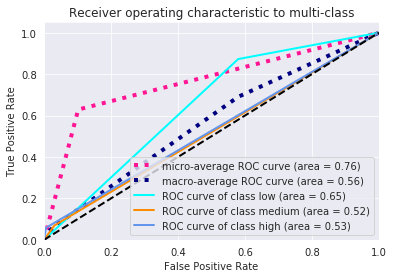

In [188]:
# apply ROC metrics of decision tree
# cite: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
X = x.copy()
y = train_data['interest_level']
y = label_binarize(y, classes=['low', 'medium', 'high'])

n_classes = y.shape[1]

X_train, X_valid, y_train, y_valid = train_test_split(X, y)
# model = RandomForestClassifier(n_estimators=1000, max_depth=10, min_samples_leaf=10)
model = DecisionTreeClassifier(max_depth=10, min_samples_leaf = 10)
# dt_model.fit(X_train, y_train)

# model = Pipeline([
# #         ('normalization', MinMaxScaler(feature_range = (0,1))),
# #         ('feature_selection', SelectKBest(f_classif, k=3)),
#         ('decision tree', DecisionTreeClassifier())
# ])

y_score = model.fit(X_train, y_train).predict(X_valid)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# # Plot of a ROC curve for a specific class
# plt.figure()
# lw = 2
# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
classes = ['low', 'medium', 'high']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [184]:
# examine overfiting and tune params
X = x.copy()
y = train_data['interest_level']
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

k = 'all'
for k in range(1,Ncols+1, 1):
    dt_model = Pipeline([
                ('normalization', MinMaxScaler(feature_range = (0,1))),
                ('feature_selection', SelectKBest(f_classif, k=k)),
                ('decision tree', DecisionTreeClassifier(max_depth=10, min_samples_leaf = 5))
        ])
    dt_model.fit(X_train, y_train)
    print(k," trainning vs. validation score: ", dt_model.score(X_train, y_train), dt_model.score(X_valid, y_valid))
    print("classification report:\n ", classification_report(y_valid , dt_model.predict(X_valid)))
#     scores = cross_val_score(dt_model, X, y, cv=5, scoring='accuracy')
#     print("score is:", scores.mean(), '\n')

1  trainning vs. validation score:  0.7072883449682553 0.6980351602895554
classification report:
                precision    recall  f1-score   support

        high       0.39      0.02      0.04       820
         low       0.70      0.99      0.82      8082
      medium       0.39      0.03      0.05      2702

    accuracy                           0.70     11604
   macro avg       0.49      0.35      0.30     11604
weighted avg       0.61      0.70      0.59     11604

2  trainning vs. validation score:  0.7103335344307506 0.69657014822475
classification report:
                precision    recall  f1-score   support

        high       0.42      0.06      0.10       820
         low       0.71      0.98      0.82      8082
      medium       0.38      0.05      0.09      2702

    accuracy                           0.70     11604
   macro avg       0.51      0.36      0.34     11604
weighted avg       0.61      0.70      0.60     11604

3  trainning vs. validation score:  0.7142

In [76]:
# # visualize decision tree
# def Visualizing_Decision_Trees(X, y, clf):
#     '''
#     Visualizing the Decision Tree, and the graph will be stored in directory
#     '''

#     dtree = DecisionTreeClassifier(max_depth=10, min_samples_leaf = 10)
#     dtree.fit(X , y)
    
# #     categary_name = ['downstairs_hold' , 'downstairs_inpocket' , 'unstairs_inpocket' , 'upstairs_hold',
# #                      'walk_hold' , 'walk_inpocket' , 'falldown_hold' , 'falldown_inpocket']
#     feature_names = list(X.columns)
#     export_graphviz(dtree, out_file = 'tree.dot' , feature_names = feature_names , rounded = True, proportion = True, 
#                 precision = 2, filled = True)

#     call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi = 600'])
#     Image(filename = 'tree.png')
    
# #     random_forest = RandomForestClassifier(n_estimators = 500)
# #     random_forest.fit(X , y)
# #     estimator = random_forest.estimators_[5]
# #     export_graphviz(estimator, out_file = 'random_forest.dot' , feature_names = feature_names , class_names = categary_name , rounded = True, proportion = False, 
# #                 precision = 2, filled = True)
# #     call(['dot', '-Tpng', 'random_forest.dot', '-o', 'random_forest.png', '-Gdpi = 600'])
# #     Image(filename = 'decision_tree.png')
# Visualizing_Decision_Trees(X_train, y_train, dt_model)

In [113]:
# apply RandomForest
X = x.copy()
y = train_data['interest_level']
X_train, X_valid, y_train, y_valid = train_test_split(X, y)
rf_model = make_pipeline(
#     MinMaxScaler(feature_range = (0,1)),
#     SelectKBest(f_classif, k=3),
    RandomForestClassifier(n_estimators=1000, max_depth=10, min_samples_leaf=10)
)
rf_model.fit(X_train, y_train)
# print("trainning vs. validation score: ", rf_model.score(X_train, y_train), rf_model.score(X_valid, y_valid))
# print("classification report:\n ", classification_report(y_valid , rf_model.predict(X_valid)))

scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("score is:", scores.mean(), '\n')
#logloss 0.79592

score is: 0.7126236296522273 



In [115]:
# predict test data using RF
rf_model.fit(X, y)
result = dt_model.predict_proba(x_test)

submit = pd.DataFrame({'listing_id':test_data['listing_id'], 'high': result[:,0], 'medium':result[:,2], 'low':result[:,1]})

submit.to_csv('submission.csv',index = False)

No handles with labels found to put in legend.


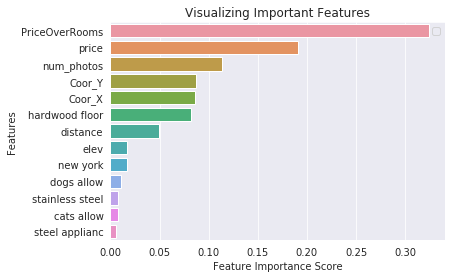

In [114]:
# show important features computed by RF
#cite: https://www.datacamp.com/community/tutorials/random-forests-classifier-python
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=10)
rf.fit(X, y)
feature_rank = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_rank, y=feature_rank.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()